In [1]:
%load_ext autoreload
%autoreload 2

# Import library

In [2]:
import sys
sys.path.append('src')
import enex_analysis as enex
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dartwork_mpl as dm
import warnings
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")
dm.use_style('dmpl_light')
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Roboto",
    "mathtext.it": "Roboto:italic",
    "mathtext.bf": "Roboto:bold",
    "mathtext.sf": "Roboto",
    "mathtext.tt": "DejaVu Sans Mono",
    "mathtext.fallback": "stix",
    "mathtext.default": "it",
})

Load colors...
Load colormaps...


# Figure function

In [3]:
def fs_dict_update(fs):
    plt.rcParams['font.size'] = fs

    fs_dict = {
        'label': dm.fs(0),
        'tick': dm.fs(-1),
        'ctick': dm.fs(-2),
        'legend': dm.fs(-2),
        'annotation': dm.fs(-1),
                }
    return fs_dict

pad = {
    'label': 6,
    'tick': 4,
}

layout ={
    'bbox': (0.1, 0.1, 0.8, 0.8),
    'margins': (0, 0, 0, 0),
}

LW = np.arange(0.25, 3.0, 0.25)

# Simulation

In [4]:
#%% 시뮬레이션 및 결과 시각화
'''
24시간 운전 시나리오
가상 시나리오는 다음과 같이 설정

초기 상태: 탱크의 모든 노드는 40°C로 균일하게 시작합니다.
외기 온도: 하루 동안 15°C에서 25°C 사이를 부드럽게 변동합니다.
온수 사용: 아침(7-8시)과 저녁(19-20시)에 집중적으로 온수를 사용합니다.
내부 히터: 탱크 하부(Node 10)에 히터가 설치되어 있으며, 이 노드의 온도가 50°C 아래로 떨어지면 작동하고 60°C 이상으로 올라가면 멈추는 자동온도조절기(Thermostat) 로직을 따릅니다.
급수 온도: 탱크로 유입되는 물의 온도는 15°C로 일정합니다.
'''

# --- 1. 시뮬레이션 설정 ---
H = 0.8; D = 0.4; N = 10 # --> 약 100 L 탱크
tank = enex.StratifiedTankTDMA(r0=D/2, x_shell=0.005, x_ins=0.05, k_shell=50, k_ins=0.04, H=H, N=N, h_w=10, h_o=5, C_d_mix=0.8)

dt = 5 # 시간 간격 (60초 = 1분)
sim_hours = 24
n_steps = int(sim_hours * enex.h2s / dt)
t_span = np.arange(n_steps) * dt # 시간 배열 [초]

T_initial_C = 40.0 # 초기 탱크 온도 [°C]
T_in_C = 15.0 # 유입수 온도 [°C]

heater_power_W = 0 # 히터 전력 [W]
heater_node = 1 # 히터 위치

thermostat_on_C = 50.0 # 서모스탯 켜짐 온도 [°C]
thermostat_off_C = 60.0 # 서모스탯 꺼짐 온도 [°C]

loop_outlet_node = 10   # 탱크 하부에서 빼서
loop_inlet_node  = 1    # 상부로 되돌림 (하향 경로)

LITER_PER_MIN_TO_M3_PER_SEC = 1/60000
dV_loop = 2.5*LITER_PER_MIN_TO_M3_PER_SEC   # [m^3/s] = 2.5 L/min 정도 예시
Q_loop  = 100 - 500 * np.cos(2 * np.pi * t_span / (24 * enex.h2s))
Q_loop = np.clip(Q_loop, 0, None)   # 하한 0, 상한 제한 없음


# --- 2. 24시간 가상 스케줄 생성 ---
# 외기 온도 스케줄 (15°C ~ 25°C 사이에서 변동)
T_amb_C = 20 - 5 * np.cos(2 * np.pi * t_span / (24 * enex.h2s))
T_amb_K = enex.C2K(T_amb_C)

# 온수 사용량(dV) 스케줄 [m³/s]
# 아침(7-9시), 저녁(19-21시)에 각 100리터 사용 가정
dV_schedule = np.zeros(n_steps)
morning_usage_L = 100
evening_usage_L = 100
morning_start_idx = int(7 * enex.h2s / dt)
morning_end_idx = int(8 * enex.h2s / dt)
evening_start_idx = int(19 * enex.h2s / dt)
evening_end_idx = int(20 * enex.h2s / dt)

# 사용 시간에 걸쳐 유량 균등 분배
dV_schedule[morning_start_idx:morning_end_idx] = (morning_usage_L * enex.L2m3) / (morning_end_idx - morning_start_idx) / dt # 단위: m³/s
dV_schedule[evening_start_idx:evening_end_idx] = (evening_usage_L * enex.L2m3) / (evening_end_idx - evening_start_idx) / dt # 단위: m³/s


# --- 3. 시뮬레이션 실행 ---
# 결과 저장을 위한 배열 초기화
T_results = np.zeros((n_steps, N))
T_now = np.full(N, enex.C2K(T_initial_C)) # 초기 온도를 Kelvin으로 설정

heater_on = False # 히터 초기 상태
for k in range(n_steps):
    # 히터 제어 (기존 로직 유지)
    heater_sensor_temp_C = enex.K2C(T_now[heater_node-1])
    heater_on = (heater_sensor_temp_C < thermostat_on_C)
    if heater_sensor_temp_C > thermostat_off_C:
        heater_on = False
    current_heater_W = heater_power_W if heater_on else 0.0

    T_next = tank.step(
        T=T_now,
        dt=dt,
        T_in=enex.C2K(T_in_C),
        dV=dV_schedule[k],           # 기존 급탕 사용 유량
        T_amb=T_amb_K[k],
        Q_heater_node=heater_node,
        Q_heater_W=current_heater_W,
        # ---- 루프 추가 인자 ----
        loop_outlet_node=loop_outlet_node,
        loop_inlet_node=loop_inlet_node,
        dV_loop=dV_loop,
        Q_loop=Q_loop[k]
    )
    T_results[k,:] = T_next
    T_now = T_next

TypeError: StratifiedTankTDMA.step() missing 1 required positional argument: 'T0'

In [ ]:
tank.info()

=== StratifiedTankTDMA :: Model Info ===
[Geometry]
  H = 0.800 m,  D = 0.400 m,  A = 0.126 m²
  N = 10 layers,  dz = 0.080 m
  V_node = 0.010 m³,  V_total = 0.101 m³
[Thermal]
  C_node = 4.21e+04 J/K,  C_total = 4.21e+05 J/K
  K_axial (conduction) = 0.952 W/K
  UA_sum = 0.999 W/K  (min 0.075, max 0.201)
[Mixing]
  C_d_mix = 0.800


# Visualization

In [5]:
fs_dict = fs_dict_update(9)
# --- 4. 결과 시각화 ---
fig, axes = plt.subplots(2,1, figsize=(dm.cm2in(14), dm.cm2in(10)))
plt.subplots_adjust(hspace=0.4)
ax1 = axes[0]
ax2 = axes[1]

xmin1, xmax1, xint1, xmar1 = 0, sim_hours, 2, 0
ymin1, ymax1, yint1, ymar1 = 0, 80, 20, 0
ymin1_tw, ymax1_tw, yint1_tw, ymar1_tw = 0, 2, 0.5, 0
ymin2, ymax2, yint2, ymar2 = 0, 800, 200, 0


t_hours = t_span * enex.s2h
T_results_C = enex.K2C(T_results)

color_ax1_twin = 'dm.red'
cmap = plt.get_cmap('dm.Marine_r')
colors = [cmap(i) for i in np.linspace(0.1, 0.9, N)]


# 각 노드(성층)별 온도 변화 플로팅
for i in range(N):
    # 최상단(Node 1)은 굵게, 최하단(Node 10)은 점선으로 표시
    # if i == 0:
    #     ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Top)', linewidth= LW[3], color=colors[i])
    # elif i == N - 1:
    #     ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Bottom)', linewidth= LW[3], color=colors[i])
    if i == loop_inlet_node-1:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Loop in)', linewidth= LW[3], color=colors[i])
    elif i == loop_outlet_node-1:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$' + '(Loop Out)', linewidth= LW[3], color=colors[i])
    else:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$', linewidth =LW[3], color=colors[i])

# 5) plot detail
ax1.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax1.set_ylabel('Temperature [°C]', fontsize=fs_dict['label'], labelpad=pad['label'])

ax1.set_xlim(xmin1 - xmar1, xmax1 + xmar1)
ax1.set_ylim(ymin1 - ymar1, ymax1 + ymar1)

# ax1.annotate(annotations, xy=(.01, 1.01), xycoords='axes fraction',
#     horizontalalignment='left', verticalalignment='bottom', fontsize=fs_dict['annotation']) 

ax1.set_xticks(np.arange(xmin1, xmax1*1.001, xint1))
ax1.set_yticks(np.arange(ymin1, ymax1*1.001, yint1))

ax1.tick_params(labelsize=fs_dict['tick'], which='major', length=2.5, width=0.3  , pad=pad['tick'])
ax1.tick_params(labelsize=fs_dict['tick'], which='minor', length=1.25, width=0.3, pad=pad['tick'])

ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc = 'upper center',fontsize=fs_dict['legend'], bbox_to_anchor=(0.5, 1.1), ncols=5,
          handlelength = 1.5, columnspacing=2, labelspacing=0.5)


# 그래프 설정
ax1.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax1.set_ylabel('Temperature [°C]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax1.set_xticks(np.arange(0, 25, 2))

# 온수 사용 시점 시각적으로 표시
ax1_twin = ax1.twinx()
ax1_twin.fill_between(t_hours, 0, dV_schedule * enex.m32L / enex.s2m, color=color_ax1_twin + '4', alpha=0.3, label='Hot water use [L/min]')
ax1_twin.set_ylabel('Hot Water Usage [L/min]', fontsize=fs_dict['label'], labelpad=pad['label'], color=color_ax1_twin + '6')

ax1_twin.set_ylim(0, ymax1_tw)

ax1_twin.set_yticks(np.arange(ymin1_tw, ymax1_tw*1.001, yint1_tw))
ax1_twin.spines['right'].set_visible(True)
ax1_twin.spines['right'].set_color(color_ax1_twin + '6')
ax1_twin.tick_params(axis='y', colors=color_ax1_twin + '6', labelsize=fs_dict['tick'], which='major', pad=pad['tick'])

# 
ax2.plot(t_hours, Q_loop, color='dm.orange', linewidth=LW[3])
# 5) plot detail
ax2.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax2.set_ylabel('Solar heat gain [W]', fontsize=fs_dict['label'], labelpad=pad['label'])

ax2.set_xlim(xmin1 - xmar1, xmax1 + xmar1)
ax2.set_ylim(ymin2 - ymar2, ymax2 + ymar2)

ax2.set_xticks(np.arange(xmin1, xmax1*1.001, xint1))
ax2.set_yticks(np.arange(ymin2, ymax2*1.001, yint2))

ax2.tick_params(labelsize=fs_dict['tick'], which='major', length=2.5, width=0.3  , pad=pad['tick'])
ax2.tick_params(labelsize=fs_dict['tick'], which='minor', length=1.25, width=0.3, pad=pad['tick'])

ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc = 'upper center',fontsize=fs_dict['legend'], bbox_to_anchor=(0.5, 1.1), ncols=5,
          handlelength = 1.5, columnspacing=2, labelspacing=0.5)


dm.simple_layout(fig, bbox=[0, 1, 0, 1], margins=[0.05, 0.05, 0.05, 0.05])
plt.savefig('figure/Tank_stratification_model/Tank_stratification_model_results(downward loop).png', dpi=300)
dm.save_and_show(fig)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


In [6]:
direction = "상향" if loop_inlet_node > loop_outlet_node else "하향"
print(f"[loop] {direction}: in={loop_inlet_node} → out={loop_outlet_node}, dV_loop={dV_loop*6e4:.1f} L/min")


[loop] 하향: in=1 → out=10, dV_loop=2.5 L/min


# Simulation

In [7]:
# --- 1. 시뮬레이션 설정 ---
H = 0.8; D = 0.4; N = 10 # --> 약 100 L 탱크
# (참고: Tank_stratification_model.py에 정의된 클래스/함수를 사용하려면 
#  별도 파일로 분리된 경우 'enex.' 대신 'Tank_stratification_model.'을 사용하거나
#  같은 파일에 있다면 'enex.' 접두사를 제거해야 합니다.)
# 여기서는 같은 파일에 있다고 가정하고 'enex.'를 제거합니다.
tank = enex.StratifiedTankTDMA(r0=D/2, x_shell=0.005, x_ins=0.05, k_shell=50, k_ins=0.04, H=H, N=N, h_w=10, h_o=5, C_d_mix=0.8)

dt = 5 # 시간 간격
sim_hours = 24
n_steps = int(sim_hours * enex.h2s / dt)
t_span = np.arange(n_steps) * dt # 시간 배열 [초]

# ... (T_initial_C, T_in_C, heater_power_W 등 나머지 설정 동일) ...
T_initial_C = 40.0; T_in_C = 15.0
heater_power_W = 0; heater_node = 1
thermostat_on_C = 50.0; thermostat_off_C = 60.0
loop_outlet_node = 10; loop_inlet_node = 1
LITER_PER_MIN_TO_M3_PER_SEC = 1/60000
dV_loop = 0*LITER_PER_MIN_TO_M3_PER_SEC
Q_loop = 100 - 500 * np.cos(2 * np.pi * t_span / (24 * enex.h2s))
Q_loop = np.clip(Q_loop, 0, None)


# --- 2. 24시간 가상 스케줄 생성 ---
T_amb_C = 20 - 5 * np.cos(2 * np.pi * t_span / (24 * enex.h2s))
T_amb_K = enex.C2K(T_amb_C)

dV_schedule = np.zeros(n_steps)
morning_usage_L = 100; evening_usage_L = 100
morning_start_idx = int(7 * enex.h2s / dt); morning_end_idx = int(8 * enex.h2s / dt)
evening_start_idx = int(19 * enex.h2s / dt); evening_end_idx = int(20 * enex.h2s / dt)
dV_schedule[morning_start_idx:morning_end_idx] = (morning_usage_L * enex.L2m3) / (morning_end_idx - morning_start_idx) / dt
dV_schedule[evening_start_idx:evening_end_idx] = (evening_usage_L * enex.L2m3) / (evening_end_idx - evening_start_idx) / dt


# --- 3. 시뮬레이션 실행 ---
# 결과 저장을 위한 배열 초기화
T_results = np.zeros((n_steps, N))
T_now = np.full(N, enex.C2K(T_initial_C))

# **** 엑서지 결과 저장을 위한 배열 추가 ****
Ex_con_cond_results = np.zeros((n_steps, N))
Ex_con_mix_results = np.zeros((n_steps, N))
Ex_con_main_results = np.zeros((n_steps, N))
Ex_con_loop_results = np.zeros((n_steps, N))
# *****************************************

heater_on = False
for k in range(n_steps):
    # 히터 제어
    heater_sensor_temp_C = enex.K2C(T_now[heater_node-1])
    heater_on = (heater_sensor_temp_C < thermostat_on_C)
    if heater_sensor_temp_C > thermostat_off_C:
        heater_on = False
    current_heater_W = heater_power_W if heater_on else 0.0

    # **** step 메소드 반환값 수정 ****
    T_next, ex_con = tank.step(
        T=T_now,
        dt=dt,
        T0=enex.C2K(20.0),  # 기준 온도 T0 추가
        T_in=enex.C2K(T_in_C),
        dV=dV_schedule[k],
        T_amb=T_amb_K[k], # T0로 사용됨
        Q_heater_node=heater_node,
        Q_heater_W=current_heater_W,
        loop_outlet_node=loop_outlet_node,
        loop_inlet_node=loop_inlet_node,
        dV_loop=dV_loop,
        Q_loop=0
    )
    # ********************************

    # 결과 저장
    T_results[k,:]           = T_next
    Ex_con_cond_results[k,:] = ex_con["conduction"]
    Ex_con_mix_results[k,:]  = ex_con["mixing"]
    Ex_con_main_results[k,:] = ex_con["main_flow"]
    Ex_con_loop_results[k,:] = ex_con["loop_flow"]
    
    T_now = T_next

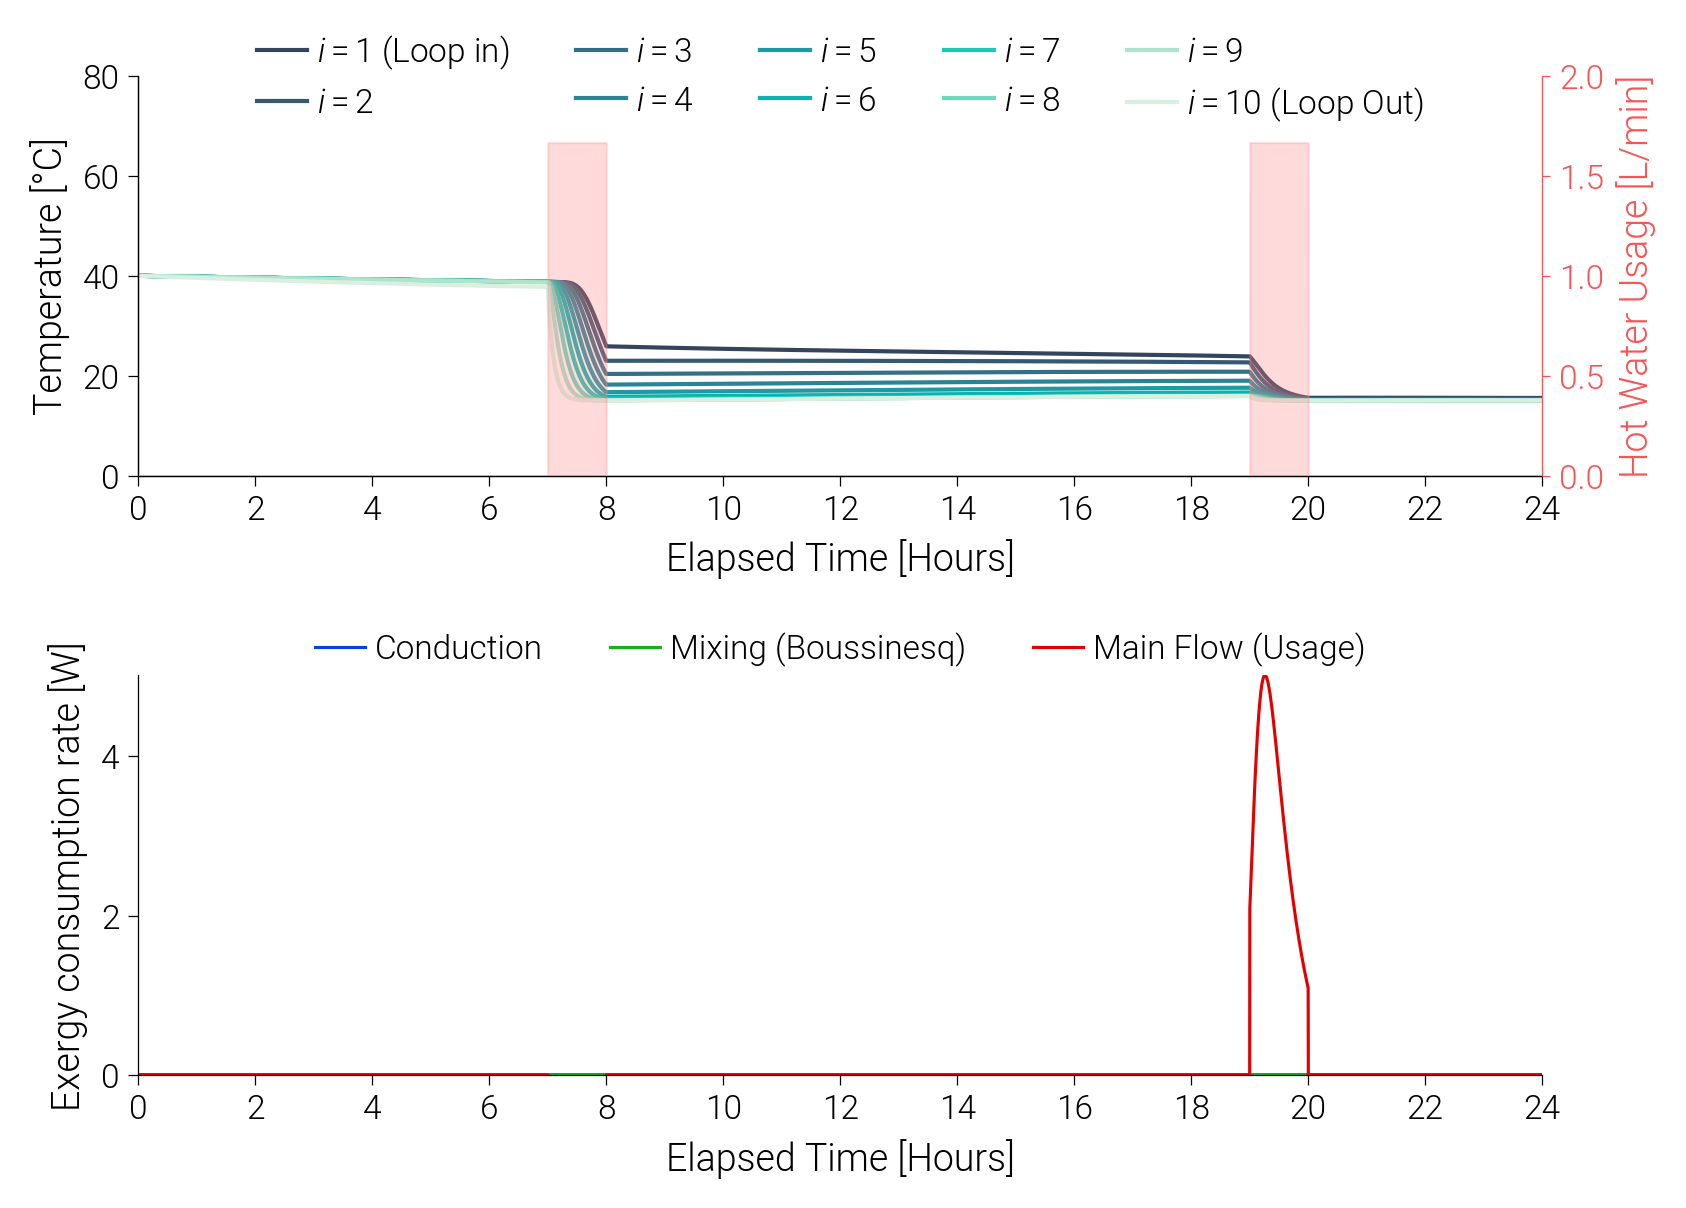

In [11]:
# (시각화를 위한 fs_dict, LW, pad, ticker 등이 정의되어 있어야 함)
# (예시용 임시 정의)
import matplotlib.ticker as ticker
fs_dict = {'label': 9, 'tick': 8, 'legend': 8}
pad = {'label': 3, 'tick': 2}
LW = [0.5, 0.75, 1, 1.5, 2]


# --- 4. 결과 시각화 (3x1 Subplot으로 변경) ---
fig, axes = plt.subplots(2, 1, figsize=(dm.cm2in(14), dm.cm2in(10))) # 높이 증가
plt.subplots_adjust(hspace=0.5) # 간격 조정
ax1 = axes[0]
ax2 = axes[1] # 엑서지 그래프용 축 추가

# ... (ax1, ax2에 대한 기존 플로팅 설정) ...
t_hours = t_span * enex.s2h
T_results_C = enex.K2C(T_results)
xmin1, xmax1, xint1, xmar1 = 0, sim_hours, 2, 0
ymin1, ymax1, yint1, ymar1 = 0, 80, 20, 0
ymin1_tw, ymax1_tw, yint1_tw, ymar1_tw = 0, 2, 0.5, 0
ymin2, ymax2, yint2, ymar2 = 0, 800, 200, 0

color_ax1_twin = 'dm.red'
cmap = plt.get_cmap('dm.Marine_r')
colors = [cmap(i) for i in np.linspace(0.1, 0.9, N)]

for i in range(N):
    if i == loop_inlet_node-1:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$ (Loop in)', linewidth= LW[2], color=colors[i])
    elif i == loop_outlet_node-1:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$ (Loop Out)', linewidth= LW[2], color=colors[i])
    else:
        ax1.plot(t_hours, T_results_C[:, i], label=f'$i = {i+1}$', linewidth =LW[2], color=colors[i])
ax1.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax1.set_ylabel('Temperature [°C]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax1.set_xlim(xmin1 - xmar1, xmax1 + xmar1); ax1.set_ylim(ymin1 - ymar1, ymax1 + ymar1)
ax1.set_xticks(np.arange(xmin1, xmax1*1.001, xint1)); ax1.set_yticks(np.arange(ymin1, ymax1*1.001, yint1))
ax1.tick_params(labelsize=fs_dict['tick'], which='major', length=2.5, width=0.3 , pad=pad['tick'])
ax1.tick_params(labelsize=fs_dict['tick'], which='minor', length=1.25, width=0.3, pad=pad['tick'])
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(1)); ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
handles, labels = ax1.get_legend_handles_labels(); ax1.legend(handles, labels, loc = 'upper center',fontsize=fs_dict['legend'], bbox_to_anchor=(0.5, 1.15), ncols=5, handlelength = 1.5, columnspacing=2, labelspacing=0.5)

ax1_twin = ax1.twinx()
ax1_twin.fill_between(t_hours, 0, dV_schedule * enex.m32L / enex.s2m, color=color_ax1_twin + '4', alpha=0.3, label='Hot water use [L/min]')
ax1_twin.set_ylabel('Hot Water Usage [L/min]', fontsize=fs_dict['label'], labelpad=pad['label'], color=color_ax1_twin + '6')
ax1_twin.set_ylim(0, ymax1_tw); ax1_twin.set_yticks(np.arange(ymin1_tw, ymax1_tw*1.001, yint1_tw))
ax1_twin.spines['right'].set_visible(True); ax1_twin.spines['right'].set_color(color_ax1_twin + '6')
ax1_twin.tick_params(axis='y', colors=color_ax1_twin + '6', labelsize=fs_dict['tick'], which='major', pad=pad['tick'])

# --- 4c. 엑서지 소비율 플로팅 (ax2) ---
# 각 메커니즘별로 탱크 전체의 총합을 계산
Ex_con_total_cond = Ex_con_cond_results.sum(axis=1)
Ex_con_total_mix =  Ex_con_mix_results.sum(axis=1)
Ex_con_total_main = Ex_con_main_results.sum(axis=1)
Ex_con_total_loop = Ex_con_loop_results.sum(axis=1)
Ex_con_total_all = Ex_con_total_cond + Ex_con_total_mix + Ex_con_total_main + Ex_con_total_loop

# 스택 플롯(Stack plot) 또는 개별 라인 플롯
ax2.plot(t_hours, Ex_con_total_cond, label='Conduction', color='dm.blue', linewidth=LW[1])
ax2.plot(t_hours, Ex_con_total_mix, label='Mixing (Boussinesq)', color='dm.green', linewidth=LW[1])
ax2.plot(t_hours, Ex_con_total_main, label='Main Flow (Usage)', color='dm.red', linewidth=LW[1])
# ax2.plot(t_hours, Ex_con_total_loop, label='Loop Flow', color='dm.orange', linewidth=LW[1])
# ax2.plot(t_hours, Ex_con_total_all, label='Total', color='black', linestyle='--', linewidth=LW[1])

ax2.set_xlabel('Elapsed Time [Hours]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax2.set_ylabel('Exergy consumption rate [W]', fontsize=fs_dict['label'], labelpad=pad['label'])
ax2.set_xlim(xmin1 - xmar1, xmax1 + xmar1)
ax2.set_xticks(np.arange(xmin1, xmax1*1.001, xint1))
ax2.tick_params(labelsize=fs_dict['tick'], which='major', length=2.5, width=0.3 , pad=pad['tick'])
ax2.tick_params(labelsize=fs_dict['tick'], which='minor', length=1.25, width=0.3, pad=pad['tick'])
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(1)); ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(1))
handles, labels = ax2.get_legend_handles_labels(); ax2.legend(handles, labels, loc = 'upper center',fontsize=fs_dict['legend'], bbox_to_anchor=(0.5, 1.15), ncols=3, handlelength = 1.5, columnspacing=2, labelspacing=0.5)
ax2.set_ylim(bottom=0) # 파괴율은 0 이상

dm.simple_layout(fig, bbox=[0, 1, 0, 1], margins=[0.05, 0.05, 0.05, 0.05])
# plt.savefig('figure/Tank_stratification_model/Tank_stratification_exergy_results.png', dpi=300)
# dm.save_and_show(fig)
plt.show()